# Open Street Map Case Study

## Location Selected: Kansas City, Missouri

Map URL: https://www.openstreetmap.org/search?query=kansas%20city%20missouri#map=10/39.0928/-94.5758

### Context:

This area is in Northwest Missouri and sits on the border of Northeast Kansas. I chose this area as it is close to my hometown, my family enjoy trips to the area, and one of our favorite baseball teams is the KC Royals. As such, I thought it'd be an interesting area to comb through and clean data.

# Note On Data File

The original OSM file I pulled for Kansas City, Missouri was 680 MB in size. This caused the timeline to clean and convert to CSV's in excess of 3.5 hours. I elected to circle back to Open Street Map and down load a "smaller search area." So for the purposes of this report / project, the OSM file size is shown below.

Note: I used the CreateSampleData.py file to create the sample OSM file.

In [2]:
from hurry.filesize import size
import os

kcmapold = "kcmapOLD.osm"
kcmapnew = "kcmap.osm"

print "Original file size is: " + size(os.path.getsize(kcmapold))
print "New 'Original' file size is: " + size(os.path.getsize(kcmapnew))

Original file size is: 680M
New 'Original' file size is: 69M


# Quick Audit of Data

The goal here was to get my bearings with the data. I set out to parse the data to understand the different tag types first.

In [3]:
#using the mapparser.py file .... code from py file is below:
import xml.etree.cElementTree as ET
import pprint


OSMFILE = "kcsample.osm"

def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in tags: 
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
    return tags
    
pprint.pprint(count_tags(OSMFILE))

{'member': 57,
 'nd': 8284,
 'node': 6189,
 'osm': 1,
 'relation': 7,
 'tag': 3713,
 'way': 1058}


Now that I know the different tag types I'll be working with, I will try to see if there are any patterns within the tag types themselves and if there are any problems off the bat that I should be worried about (e.g. - Problem Characters).

In [4]:
#using the tags.py file .... code from py file is below. Code was obtained from Udacity problem set:
import xml.etree.cElementTree as ET
import pprint
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        for tag in element.iter("tag"):
            k = tag.attrib['k']
            if lower.match(k):
                keys['lower'] = keys['lower'] + 1
            elif lower_colon.match(k):
                keys['lower_colon'] = keys['lower_colon'] + 1
            elif problemchars.match(k):
                keys['problemchars'] = keys['problemchars'] + 1
                print k
            else:
                keys['other'] = keys['other'] + 1
        pass

    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys



def test():
    # You can use another testfile 'map.osm' to look at your solution
    # Note that the assertion below will be incorrect then.
    # Note as well that the test function here is only used in the Test Run;
    # when you submit, your code will be checked against a different dataset.
    keys = process_map('kcsample.osm')
    pprint.pprint(keys)


if __name__ == "__main__":
    test()

{'lower': 2079, 'lower_colon': 1578, 'other': 56, 'problemchars': 0}


# Problems with Dataset

Below are the problems I identified with the problem set:

- County information had a couple of "dual names" listed.
- Multiple variants of the same street names present.
- Only numeric values present for a few street names, so will need to confirm they're legitimate street numbers.
- Some street information seems to be duplicated with the "tiger:*attribute*" value and will need to be checked out.


I created a sample data OSM from the original 'kcmap.osm' file. The original file is 680MB in size.

Originally, I ran the Python code to list all unique users in the data. The list was fairly lengthy. So, I modified the original code with what is shown below to kick out the quantity of unique user ID's vs. just the list of all unique user ID's.

In [5]:
import re

def get_user(element):
    return


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):

        for tag in element.iter():
            if 'uid' in tag.attrib.keys():
                users.add(tag.attrib['uid'])


    return len(users)


def test():

    users = process_map('kcsample.osm')
    pprint.pprint(users)




if __name__ == "__main__":
    test()

77


I was curious if there was a "top 100" list of sorts (for lack of a better term) of folks who contribute to updating the Kansas City area's street map data. Below is code I worked on from class (and researched) to find and list those folks who contributed (50) or more times to the data. I decided to modify the code to pull usernames instead of ID's. If for nothing else, it helps me better understand the "people" behind the data manipulation and/or contribution.

In [6]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint
from operator import itemgetter # source: https://stackoverflow.com/questions/11228812/print-a-dict-sorted-by-values

"""
Your task is to explore the data a bit more.
The first task is a fun one - find out how many unique users
have contributed to the map in this particular area!
The function process_map should return a set of unique user IDs ("uid")
"""

osmfile = "kcsample.osm"

def get_user(element):
    if element.tag in ["node", "way", "relation"]:
        return element.attrib["user"]
    else:
        return None

def get_all_users(filename):
    users = defaultdict(int)
    for _, element in ET.iterparse(filename):
        uid = get_user(element)
        if(uid):
            users[uid] += 1
    for k, v in sorted(users.items(), key=itemgetter(1), reverse=True):
        if v >= 50: #there are a ton of users listed, so looking for those who make 50 or more changes in the data
            print k, v
#    return users


print(get_all_users(osmfile))

sannkc 5579
bspecht 214
railfan-eric 212
schaaf 210
PHerison 186
Sabra Sharaya 185
balcoath 88
UAN51 71
NE2 71
woodpeck_fixbot 69
None


In my first OSM file download from OpenStreetMaps, I noticed that "James Michael Dupont" actually shows up twice. Apparently, he has a login for his mobile because he's also listed under "james michael dupont mobile." I don't plan to pursue this as a clean-up effort for the project, but it is an interesting find. Additionally, it appears to me that there are bots that modify data here. For example, I see the name "bot-mode" has a count of (147). This is something that, while it doesn't show up in my reduced file size, would be something to investigate outside of this project (aka - if this were an actual business case scenario).

From here, I wanted to check out the number of unique street names to see if any cleaning needs to be done.

In [7]:
from collections import defaultdict

osm_file = open("kcsample.osm", "r")

street_type_re = re.compile(r'\S+\.?$', re.IGNORECASE)
street_types = defaultdict(int)

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()

        street_types[street_type] += 1

def print_sorted_dict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v)

def is_street_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "addr:street")

def audit():
    for event, elem in ET.iterparse(osm_file):
        if is_street_name(elem):
            audit_street_type(street_types, elem.attrib['v'])
    print_sorted_dict(street_types)

if __name__ == '__main__':
    audit()

Avenue: 118
Boulevard: 19
Chavez: 2
Court: 1
Paseo: 5
Place: 2
Road: 5
St: 1
Street: 79
Terrace: 2
Way: 1


At first glance, I see that there are a few street names I'd like to clean up (e.g. - Street, Circle, and Boulevard). One thing I'm also curious about is the county names and whether or not that needs cleaning as well. I modified my original "street name audit" code to look for the county information (see below):

In [8]:
osm_file = open("kcsample.osm", "r")
# changed the 'S' to a 'D' to pull in the entire string from the tiger:county attribute
county_type_re = re.compile(r'\D+\.?$', re.IGNORECASE)
county_types = defaultdict(int)

def audit_county_type(county_types, county_name):
    m = county_type_re.search(county_name)
    if m:
        county_type = m.group()

        county_types[county_type] += 1

def print_sorted_dict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v)
#Looking for tags that have the attribute of 'tiger:county' so I can see the counties listed in my data sample
def is_county_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "tiger:county") #changed the focus to county instead of street name

def audit():
    for event, elem in ET.iterparse(osm_file):
        if is_county_name(elem):
            audit_county_type(county_types, elem.attrib['v'])
    print_sorted_dict(county_types)

if __name__ == '__main__':
    audit()

Jackson, MO: 41
Jackson, MO:Wyandotte, KS: 1
Wyandotte, KS: 11


## From My Original 'kcmap' OSM File
From personal experience, I know there's a 'Johnson county' in both Missouri and Kansas... so that's fine. I researched the 'Cass, MO:Jackson, MO' and 'Douglas, KS:Franklin,KS' ones to see if I can clarify where that data is pointed. As it turns out in both instances, the first county name is accurate. The reason I noticed (via looking at the map) is that the data point is very close to the adjacent county, which is also named as the second county. In both instances, I plan to remove the second county name. 

I looked into the data for the "Benton, MO: .... " call-out above as well. Upon further research, I noticed that it has a "fixme" tag tied to it. When I looked that up, it confirms my suspicion that it's flagged for clarification and review. That data isn't reliable to me.

## From My New 'kcmap' OSM File

I still see that double counties exist in the records (e.g. - Jackson, MO:Wyandotte, KS. This simply confirms my original thinking above.

My approach now is to (a) clean up the street names (taking care of any numbered streets by adding "street" for clarity) and (b) clean up the counties.

After running the StreetNameClean.py file, I re-ran the StreetNameAudit.py file (using the kcsamplecleaned.osm file) to see if it worked.

In [9]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re

osmFile = open("kcsampleclean1.osm", "r")

street_type_re = re.compile(r'\S+\.?$', re.IGNORECASE)
streetTypes = defaultdict(int)

#Finding and counting the street names or "types"
def audit_street_type(streetTypes, streetName):
    m = street_type_re.search(streetName)
    if m:
        street_type = m.group()

        streetTypes[street_type] += 1

#using this to print the sorted dictionary
def printSortedDict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v)

#Using this to verify if the element is actually the street name attribute
def isStreetName(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "addr:street")

#doing the actual auditing here
def audit():
    for event, elem in ET.iterparse(osmFile):
        if isStreetName(elem):
            audit_street_type(streetTypes, elem.attrib['v'])
    printSortedDict(streetTypes)

if __name__ == '__main__':
    audit()

Avenue: 118
Boulevard: 19
Chavez: 2
Court: 1
Paseo: 5
Place: 2
Road: 5
Street: 80
Terrace: 2
Way: 1


Looks much better! Now it's time to figure out how to clean up the county names. Using the cleanCounty.py file, I re-ran the countyAudit.py file to see how it played out.

In [10]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re

osmFile = open("kcsampleclean2.osm", "r")
# changed the 'S' to a 'D' to pull in the entire string from the tiger:county attribute
county_type_re = re.compile(r'\D+\.?$', re.IGNORECASE)
countyTypes = defaultdict(int)

def auditCountyType(countyTypes, countyName):
    m = county_type_re.search(countyName)
    if m:
        countyType = m.group()

        countyTypes[countyType] += 1

def printSortedDict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v)
#Looking for tags that have the attribute of 'tiger:county' so I can see the counties listed in my data sample
def is_county_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "tiger:county") #changed the focus to county instead of street name

def audit():
    for event, elem in ET.iterparse(osmFile):
        if is_county_name(elem):
            auditCountyType(countyTypes, elem.attrib['v'])
    printSortedDict(countyTypes)

if __name__ == '__main__':
    audit()

Jackson, M: 41
Jackson, MO: 1
Wyandotte, K: 11


Better.... but I noticed some "fall-out" from my cleaning efforts. It looks like some county names lost their last "O" or "S" respectively, which is causing the county totals to not be counted as a single name if you will. I attempted multiple variations of my python file, but ended up losing more of the county information than I was comfortable with. I elected to focus on the "better names" approach and run my cleanCounty2.py file to clean up those counties missing the "O" or "S" as shown above.

In [11]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re

osmFile = open("kcsampleclean3.osm", "r")
# changed the 'S' to a 'D' to pull in the entire string from the tiger:county attribute
county_type_re = re.compile(r'\D+\.?$', re.IGNORECASE)
countyTypes = defaultdict(int)

def auditCountyType(countyTypes, countyName):
    m = county_type_re.search(countyName)
    if m:
        countyType = m.group()

        countyTypes[countyType] += 1

def printSortedDict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v)
#Looking for tags that have the attribute of 'tiger:county' so I can see the counties listed in my data sample
def is_county_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "tiger:county") #changed the focus to county instead of street name

def audit():
    for event, elem in ET.iterparse(osmFile):
        if is_county_name(elem):
            auditCountyType(countyTypes, elem.attrib['v'])
    printSortedDict(countyTypes)

if __name__ == '__main__':
    audit()

Jackson, MO: 42
Wyandotte, KS: 11


Now we're talking!!! I ended up creating a couple of python files to address this (cleanCounty.py & cleanCounty2.py). The cleanCounty.py file stripped down the attributes that had multiple counties in them. The cleanCounty2.py file focused on correcting the stripped names to show the 2-character state abbreviations.

I love seeing how much time and effort spent figuring out how to lay out the code structure and then to be able to modify it to also take care of county information.... this is why I love data science!

# Problem Check-Up

At this point, I have addressed the following items that I discovered for data wrangling / cleaning:

- County information had a couple of "dual names" listed.
- Multiple variants of the same street names present.

# Additional Clean-Up Opportunity

As previously stated in this document, one area of cleaning that could be looked into is the user names. As previously noted, there were multiple versions of the same person (at least one I discovered) that could be merged to clean that area up a little. One thing to note is by doing so, I am not sure whether or not there'd be impact to the data one "user" would have over the other if that makes sense and would need to ensure there's no data loss by merging the two names together. The benefit in pursuing this, however, would be one more step taken to reduce confusion as to who all / how many folks are participating in this area's up-keep of data. 

Finally, I did notice that the cities need some cleaning as well to remove unnecessary capitalizations (as an example). Again, something that should be investigated and could be handled outside of this project.

# Onward to SQL

I ran my cleanData.py file to take the original "kcmap.osm" file and:

- run it through the cleaning Python files like I show earlier in this document
- convert it from XML / OSM file into (5) CSV files in preparation to upload into a database file (and applicable tables) for SQLITE.

Now that my code has completed regarding the OSM cleaning and conversion to (5) CSV files, I will create the database and subsequent tables for these CSV's to live in (ref: importToDB.py). Below are the respective queries I wrote to view the data within the "kcmap.db" to verify things are functioning as they should.

### Screenshots Confirming SQL Database and Tables Were Created

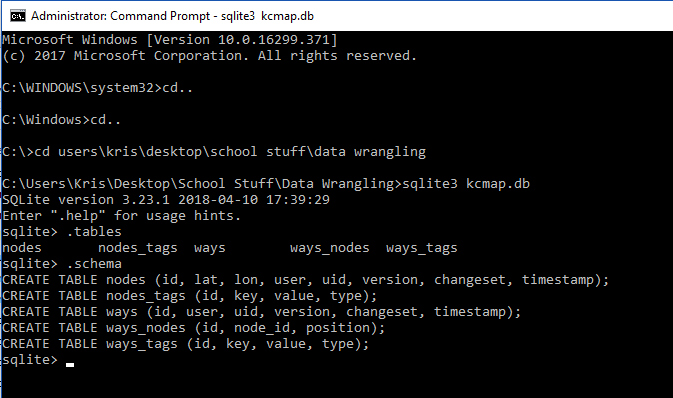

# SQL Queries Using Python

In [12]:
import sqlite3
import QueryTest
import os
from hurry.filesize import size

con = sqlite3.connect("kcmap.db")
cur = con.cursor()

print "#######File Sizes:#######"
QueryTest.fileSizes()

#######File Sizes:#######
kcmap.osm file is 69M.
kcmap.db file is 49M.
nodes.csv file is 24M.
nodes_tags.csv file is 802K.
ways.csv file is 2M.
ways_tags.csv file is 5M.
ways_nodes.csv file is 9M.


In [13]:
print "####Number of Nodes####"
QueryTest.numberOfNodes()

####Number of Nodes####


309430

In [14]:
print "####Number of Ways####"
QueryTest.numberOfWays()

####Number of Ways####


52903

In [15]:
print "####Verify Data is in a Table####"
print "######With 10 Rows of Data#######"
print
QueryTest.grabaRow()

####Verify Data is in a Table####
######With 10 Rows of Data#######



[(u'65613479',
  u'39.1148918',
  u'-94.6080688',
  u'PHerison',
  u'28378',
  u'59',
  u'5188623',
  u'2010-07-11T10:02:59Z'),
 (u'65613480',
  u'39.1131167',
  u'-94.6060539',
  u'PHerison',
  u'28378',
  u'58',
  u'4781048',
  u'2010-05-23T08:57:26Z'),
 (u'65613482',
  u'39.1113519',
  u'-94.6035649',
  u'PHerison',
  u'28378',
  u'58',
  u'4781048',
  u'2010-05-23T08:57:26Z'),
 (u'65613483',
  u'39.1101198',
  u'-94.6003891',
  u'PHerison',
  u'28378',
  u'58',
  u'4781048',
  u'2010-05-23T08:57:26Z'),
 (u'65613485',
  u'39.1104528',
  u'-94.5944668',
  u'PHerison',
  u'28378',
  u'58',
  u'4781048',
  u'2010-05-23T08:57:26Z'),
 (u'65613498',
  u'39.1461423',
  u'-94.5339387',
  u'PHerison',
  u'28378',
  u'58',
  u'4781048',
  u'2010-05-23T08:57:28Z'),
 (u'65613524',
  u'39.1658940',
  u'-94.4005291',
  u'PHerison',
  u'28378',
  u'58',
  u'5143676',
  u'2010-07-05T17:20:45Z'),
 (u'65613525',
  u'39.1682896',
  u'-94.3943279',
  u'PHerison',
  u'28378',
  u'58',
  u'5143676',
  u'

In [16]:
print '####Number of Counties####'
print '####In Descending Order####'
QueryTest.countCounties()

####Number of Counties####
####In Descending Order####


[(u'Jackson, MO', 1883),
 (u'Wyandotte, KS', 631),
 (u'Clay, MO', 29),
 (u'Platte, MO', 1)]

In [17]:
print "####Top 10 Street Names in Descending Order####"
QueryTest.topStreet()

####Top 10 Street Names in Descending Order####


[(u'Main Street', 17),
 (u'Grand Boulevard', 13),
 (u'East 18th Street', 10),
 (u'Southwest Boulevard', 10),
 (u'Prospect Avenue', 9),
 (u'Walnut Street', 9),
 (u'East 14th Street', 8),
 (u'Delaware Street', 7),
 (u'Baltimore Avenue', 4),
 (u'East Missouri Avenue', 4),
 (u'East 13th Street', 3)]

In [18]:
print "####Top 10 Contributors to KC Map####"
print "#########In Descending Order#########"
QueryTest.topUsers()

####Top 10 Contributors to KC Map####
#########In Descending Order#########


[(u'sannkc', 278249),
 (u'railfan-eric', 10886),
 (u'bspecht', 10603),
 (u'schaaf', 10338),
 (u'PHerison', 9622),
 (u'Sabra Sharaya', 9242),
 (u'balcoath', 4642),
 (u'UAN51', 3560),
 (u'woodpeck_fixbot', 3267),
 (u'NE2', 3142)]

In [19]:
print "####Top 10 Traffic Features on Highways####"
QueryTest.trafficTech()

####Top 10 Traffic Features on Highways####


[(u'crossing', 2738),
 (u'street_lamp', 782),
 (u'bus_stop', 704),
 (u'traffic_signals', 380),
 (u'motorway_junction', 129),
 (u'turning_circle', 43),
 (u'stop', 35),
 (u'give_way', 8),
 (u'turning_loop', 4),
 (u'steps', 2)]

In [20]:
print "####Top 10 Cities#####"
QueryTest.countCities()

####Top 10 Cities#####


[(u'Kansas City', 11463),
 (u'Kansas City, MO', 86),
 (u'Kansas CIty, KS 66101', 1),
 (u'kansas city', 1)]

# Final Thoughts

Overall, this project was definitely the most challenging of my degree program yet. It was also the most interesting and "real world" scenario. This kept things interesting as I went through a lot of unknown territories putting this all together. I spent significant time researching and trying to understand how to accomplish the goals set forth in this project and ensure that I was able to code and talk through it in my own way. Aside from the "XML to CSV" aspect of this project, I feel I have been successful. I have also realized that there is so much more to SQL queries than I originally thought. 

This has definitely solidified my motivation to learn more about Data Science. I look forward to the next challenge... and a break from staring so much at "iterparse" and "ET" through the midnight hours.

# Sources Used Throughout This Project

- https://discussions.udacity.com/t/auditing-street-names-unicode-problem/351420/9
- https://docs.python.org/2/library/xml.etree.elementtree.html
- https://www.python-course.eu/lambda.php
- https://stackoverflow.com/questions/13669252/what-is-key-lambda
- http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
- https://anh.cs.luc.edu/python/hands-on/3.1/handsonHtml/files.html
- https://classroom.udacity.com/nanodegrees/nd002/parts/0021345404/modules/316820862075461/lessons/5436095827/concepts/54456296460923
- https://classroom.udacity.com/nanodegrees/nd002/parts/0021345404/modules/316820862075461/lessons/5436095827/concepts/54411202700923
- http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
- https://www.debuggex.com/cheatsheet/regex/python 
- https://www.youtube.com/watch?v=sa-TUpSx1JA
- https://docs.python.org/3.2/library/re.html
- https://discussions.udacity.com/t/lesson-3-8-example-using-our-blueprint/158483/2
- https://discussions.udacity.com/t/validating-a-complex-query-how-to-find-ids-with-a-missing-key/180994
- https://discussions.udacity.com/t/wrangle-openstreet-data-sql-queries/310013/3
- https://discussions.udacity.com/t/sqlite-number-of-user-contributions-query/198564
- https://www.systutorials.com/241542/how-to-get-file-size-in-python/
- http://thepythonguru.com/fetching-results/
- https://docs.python.org/2/library/sqlite3.html
- https://stackoverflow.com/questions/9545637/sql-order-by-count
- https://discussions.udacity.com/t/wrangle-openstreet-data-sql-queries/310013/2
- https://gist.github.com/carlward/54ec1c91b62a5f911c42#file-sample_project-md
- https://discussions.udacity.com/t/validating-a-complex-query-how-to-find-ids-with-a-missing-key/180994
- https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python
- https://discussions.udacity.com/t/creating-db-file-from-csv-files-with-non-ascii-unicode-characters/174958
- https://discussions.udacity.com/t/difficulty-with-inserting-csv-file-and-sql-query/186125/3
- https://discussions.udacity.com/t/datatype-mismatch-issue-with-sql-import/199907
- https://discussions.udacity.com/t/osm-project-importing-csv-to-tables/177405
- https://discussions.udacity.com/t/final-project-data-wrangling-p3/195936/32
- https://docs.python.org/2.5/lib/sqlite3-Cursor-Objects.html
- https://stackoverflow.com/questions/11228812/print-a-dict-sorted-by-values
- https://anh.cs.luc.edu/python/hands-on/3.1/handsonHtml/files.html
